<a href="https://colab.research.google.com/github/sanat-sh/MATH540_Boosting_EmpiricalErrorBoundVerification/blob/main/MATH540_Boosting_ErrorBound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Empirical Verification of the Error Bound for Boosting

Student Name: Sanat Shukurov

## Introduction

Boosting is a ensemble method that combines several classifiers with sub-optimal performance in a way that decreases the overall error. This project aims to verify the theoretical bound on the true error of boosting methods, and, specifically, the *AdaBoost* algorithm. The theoretical derivation of the error bound can be found in "*Foundations of machine learning*" (M. Mohri, A. Rostamizadeh, and A. Talwalkar, 2018), where it is given as a function of the confidence parameter $\delta$ as follows:
\begin{equation}
R(h)\leq\hat{R}_{S,\rho}(h)+\frac{2}{\rho}\sqrt{\frac{2d\log{\frac{em}{d}}}{m}}+\sqrt{\frac{\log{\frac{1}{\delta}}}{2m}},
\tag{1}
\end{equation}
where $R(h)$ - true error, ${R}_{S,\rho}(h)$ - empirical margin error, $\rho$ - non-negative margin, $m$ - sample size, $d$ - VC dimension of its hypothesis set. For the decision trees of depth $k$, the VC dimension is $2^k$.

To run the program, firstly, run all of the code cells up to the section titled "Empirical error bound verification on the generated data" and, then, run the particular cell that computes the error as a function of the parameter of interest. The following cell is used to download the necessary packages that include the toy datasets, classifiers, train/test splitting function, etc.

In [1]:
from sklearn import datasets as ds
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In general, the true error is unobtainable, but, under certain conditions, it can be well approximated by the test error. Additionally, the empirical margin loss can be upper bounded by the fraction of the points labeled as $y$ with the confidence margin $\rho$. The test error and the empirical margin loss are defined in the cell below.

In [2]:
def empMarginLoss(y_pred, y_true, rho):
  RSrho = np.sum(np.multiply(y_pred, y_true)<=rho)/np.size(y_true)
  return RSrho

def empLoss(y_pred, y_true):
  RS = np.sum(np.exp(-np.multiply(y_pred,y_true)))/np.size(y_true)
  return RS

## Empirical error bound verification on the generated data

The following cell computes the difference between the train error and the empirical margin loss for a generated dataset using the decision tree estimators of depth ranging from $1$ to $10$.

To verify that the theoretical error bound holds, the ratio of $R(h)-\hat{R}_{S,\rho}(h)$ and $\sqrt{2d\log{(em/d)}}$ is plotted as a function of $d$. Assuming the bound holds, the plotted quantity should approach some constant value since the ratio is independent of $d$. Note that the third term on the right side of the error bound inequality (eq. (3)) has been dropped, because $\delta$ is arbitrary and can be chosen so that the third term vanishes.

In [3]:
# Error as a function of VC dimension (or decision tree depth)

# Initialize the parameters
rho        = 0.1
depth      = np.linspace(1, 10, 11, dtype=int)
m          = 1000

# Find the value of the term dependent on the VC dimension
errorValue = []
errorBound = np.sqrt(np.multiply(np.log(np.e*m/2**depth), 2**depth))

# Generate the data with subtle noise (controlled by flip_y)
X, y = ds.make_classification(n_samples=m, n_features=20, n_informative=20, n_redundant=0, n_classes=2, n_clusters_per_class=1, flip_y=0.01, random_state=42)
# Generated data is labeled from {0,1}, so change labels to {-1,+1} as required by the error bound derivation
y = 2*y-1
# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Application of AdaBoost with trees of different depth
for k in depth:
  regr = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy", max_depth=k), n_estimators=10, random_state=42)
  regr.fit(X_train, y_train)
  # As per the assumption used in the derivation of the bound, normalize the weight coefficients
  regr.estimator_weights_ = regr.estimator_weights_/np.sum(regr.estimator_weights_)
  errorValue.append(empLoss(regr.predict(X_test), y_test)-empMarginLoss(regr.predict(X_test), y_test, rho))

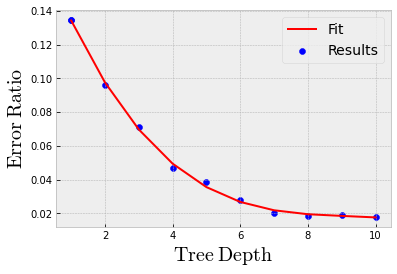

In [6]:
# Plot for the error ratio as a function of the decision tree depth

# Fit the data points using the polyfit function for plotting
fitCoeff = np.polyfit(depth, np.divide(errorValue, errorBound), 3)
p        = np.poly1d(fitCoeff)

fig, ax = plt.subplots()
plt.style.use("bmh")
# Plot the data points and the fitted line
ax.scatter(depth, np.divide(errorValue, errorBound), marker="o", color="blue", label="Results")
plt.plot(depth, p(depth), color="red", label="Fit")
ax.set_ylabel(r"$\rm Error\;Ratio$", fontsize=20)
ax.set_xlabel(r"$\rm Tree\;Depth$", fontsize=20)
plt.legend(prop={'size': 14})
plt.show()
# Save the figure if necessary
# fig.savefig(fname="depth_GenData.pdf", dpi=400, format="pdf")

As expected, for sufficiently large tree depth, the test error approaches the error bound resulting in the plotted ratio becoming independent of the decision tree depth.

The cell below performs the similar function as the previous one except that the parameter is the sample size $m$ instead of the tree depth $d$.

In [7]:
# Error as a function of sample size
rho        = 0.1
depth      = 3
m          = np.linspace(50, 5000, 100, dtype=int)

# The term dependent on the sample size is computed below
errorValue = []
errorBound = np.sqrt(np.divide(np.log(np.e*m/2**depth), m))

for k in m:
  # Since the sample size changes, new sample is generated every itteration
  X, y = ds.make_classification(n_samples=k, n_features=20, n_informative=20, n_redundant=0, n_classes=2, n_clusters_per_class=1, flip_y=0.0, random_state=42)
  # The labels are again changed to {-1,+1}
  y = 2*y-1
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  regr = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy", max_depth=depth), n_estimators=10, random_state=42)
  regr.fit(X_train, y_train)
  # The weights are again normalized
  regr.estimator_weights_ = regr.estimator_weights_/np.sum(regr.estimator_weights_)
  errorValue.append(empLoss(regr.predict(X_test), y_test)-empMarginLoss(regr.predict(X_test), y_test, rho))

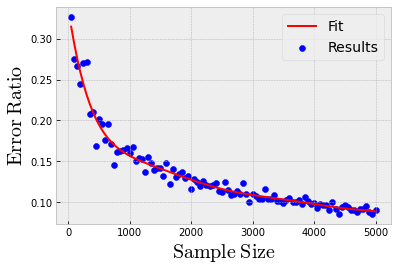

In [8]:
# Plot for the error ratio as a function of the sample size
fitCoeff = np.polyfit(m, np.divide(errorBound, errorValue), 7)
p        = np.poly1d(fitCoeff)

fig, ax = plt.subplots()
plt.style.use("bmh")
ax.scatter(m, np.divide(errorBound, errorValue), marker="o", color="blue", label="Results")
plt.plot(m, p(m), color="red", label="Fit")
ax.set_ylabel(r"$\rm Error\;Ratio$", fontsize=20)
ax.set_xlabel(r"$\rm Sample\;Size$", fontsize=20)
plt.legend(prop={'size': 14})
plt.show()
# Save the figure if necessary
# fig.savefig(fname="m_GenData.pdf", dpi=400, format="pdf")

Again, for a sufficiently large sample size, the plotted ratio becomes independent of $m$ verifying the error bound.

## Empirical error bound verification on the real data

The following cells repeat the procedure done above using the real-life dataset from the breast-cancer research. The dataset is available through the `scikit` package.

In [9]:
# Error as a function of VC dimension (or decision tree depth) for a real-life dataset
dataset    = ds.load_breast_cancer()
rho        = 0.1
depth      = np.linspace(1, 10, 11, dtype=int)
m          = 1000
errorValue = []
errorBound = np.sqrt(np.multiply(np.log(np.e*m/2**depth), 2**depth))

X, y = dataset.data, dataset.target
y = 2*y-1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

for k in depth:
  regr = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy", max_depth=k), n_estimators=10, random_state=42)
  regr.fit(X_train, y_train)
  regr.estimator_weights_ = regr.estimator_weights_/np.sum(regr.estimator_weights_)
  errorValue.append(empLoss(regr.predict(X_test), y_test)-empMarginLoss(regr.predict(X_test), y_test, rho))

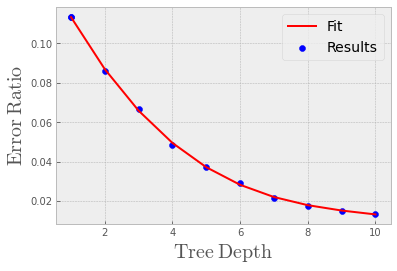

In [11]:
# Plot for the error ratio as a function of the decision tree depth for a real-life set
fitCoeff = np.polyfit(depth, np.divide(errorValue, errorBound), 3)
p        = np.poly1d(fitCoeff)

fig, ax = plt.subplots()
plt.style.use("bmh")
ax.scatter(depth, np.divide(errorValue, errorBound), marker="o", color="blue", label="Results")
plt.plot(depth, p(depth), color="red", label="Fit")
ax.set_ylabel(r"$\rm Error\;Ratio$", fontsize=20)
ax.set_xlabel(r"$\rm Tree\;Depth$", fontsize=20)
plt.legend(prop={'size': 14})
plt.show()
# Save the figure if necessary
# fig.savefig(fname="depth_RealData.pdf", dpi=400, format="pdf")

In [12]:
# Error as a function of sample size for a real-life dataset
dataset    = ds.load_breast_cancer()
rho        = 0.1
depth      = 3
m          = np.linspace(40, 560, 53, dtype=int)
errorValue = []
errorBound = np.sqrt(np.divide(np.log(np.e*m/2**depth), m))

for k in m:
  Xk = dataset.data[0:k,:]
  yk = dataset.target[0:k]
  y = 2*y-1
  X_train, X_test, y_train, y_test = train_test_split(Xk, yk, test_size=0.3, random_state=42)

  regr = AdaBoostClassifier(DecisionTreeClassifier(criterion="entropy", max_depth=depth), n_estimators=10, random_state=42)
  regr.fit(X_train, y_train)
  regr.estimator_weights_ = regr.estimator_weights_/np.sum(regr.estimator_weights_)
  errorValue.append(empLoss(regr.predict(X_test), y_test)-empMarginLoss(regr.predict(X_test), y_test, rho))

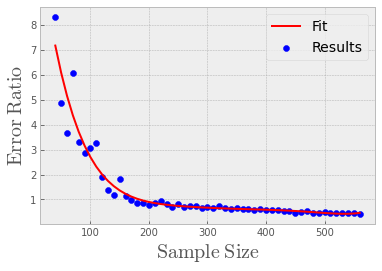

In [13]:
# Plot for the error ratio as a function of the sample size for a real-life set
fitCoeff = np.polyfit(m, np.divide(errorBound, errorValue), 6)
p        = np.poly1d(fitCoeff)

fig, ax = plt.subplots()
plt.style.use("bmh")
ax.scatter(m, np.divide(errorBound, errorValue), marker="o", color="blue", label="Results")
plt.plot(m, p(m), color="red", label="Fit")
ax.set_ylabel(r"$\rm Error\;Ratio$", fontsize=20)
ax.set_xlabel(r"$\rm Sample\;Size$", fontsize=20)
plt.legend(prop={'size': 14})
plt.show()
# Save the figure if necessary
# fig.savefig(fname="m_RealData.pdf", dpi=400, format="pdf")